Acknowledgement: This project was largely motivated by the work of Michelle Lochner et al. (ApJ Supplement Series, 225:31, 2016), which can be accessed via this [link](https://iopscience.iop.org/article/10.3847/0067-0049/225/2/31).

In [18]:
# Note that this notebook was run on Google Colab,
# therefore, mounting it to Phong's Google Drive was necessary.
# If one runs it via Jupyter, this is not needed.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# When run locally via Jupyter, change dir to 'data/'
#dir = '/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/data/' # Phong
dir = '/content/drive/My Drive/ML_Fall2025_Supernovae/updated_data/' # Valarie

Mounted at /content/drive


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#adjust font sizes for visibility on slides
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
})

# Step 1: Data Analysis

## First, we load datasets of both models.

In [22]:
# Model 1:
I_Ia = pd.read_csv(dir + 'model1_TypeIa_updated.csv').dropna()
I_Ibc = pd.read_csv(dir + 'model1_TypeIbc_updated.csv').dropna()
I_II = pd.read_csv(dir + 'model1_TypeII_updated.csv').dropna()
I_IIn = pd.read_csv(dir + 'model1_TypeIIn_updated.csv').dropna()
I_skip = ['sn_name', 'sn_type', 'band']
I_labels = ['Ia', 'Ibc', 'II', 'IIn']

In [21]:
# Model 2:
II_Ia = pd.read_csv(dir + 'model2_TypeIa_updated.csv').dropna()
II_Ibc = pd.read_csv(dir + 'model2_TypeIbc_updated.csv').dropna()
II_II = pd.read_csv(dir + 'model2_TypeII_updated.csv').dropna()
II_IIn = pd.read_csv(dir + 'model2_TypeIIn_updated.csv').dropna()
II_skip = ['sn_name', 'sn_type', 'band']
II_labels = ['Ia', 'Ibc', 'II', 'IIn']

Next, we inspect the statistics of the features in each dataset.

In [23]:
def histogram_all(dfs, skip, labels):
    cols = [c for c in dfs[0].columns if c not in skip] #dfs[0].columns[2:] to show bands

    n = len(cols)
    rows = (n + 2) // 2    # number of rows needed
    fig, axes = plt.subplots(rows, 2, figsize=(12, 3*rows))

    axes = axes.flatten()  # flatten so we can index axis[i]

    for i, column in enumerate(cols):
        ax = axes[i]

        # Plot histograms from all three datasets
        for j in range(len(dfs)):
            ax.hist(dfs[j][column], bins=30, alpha=0.5, label=labels[j])

        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        ax.legend()

    # Hide unused axes if columns not multiple of 3
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

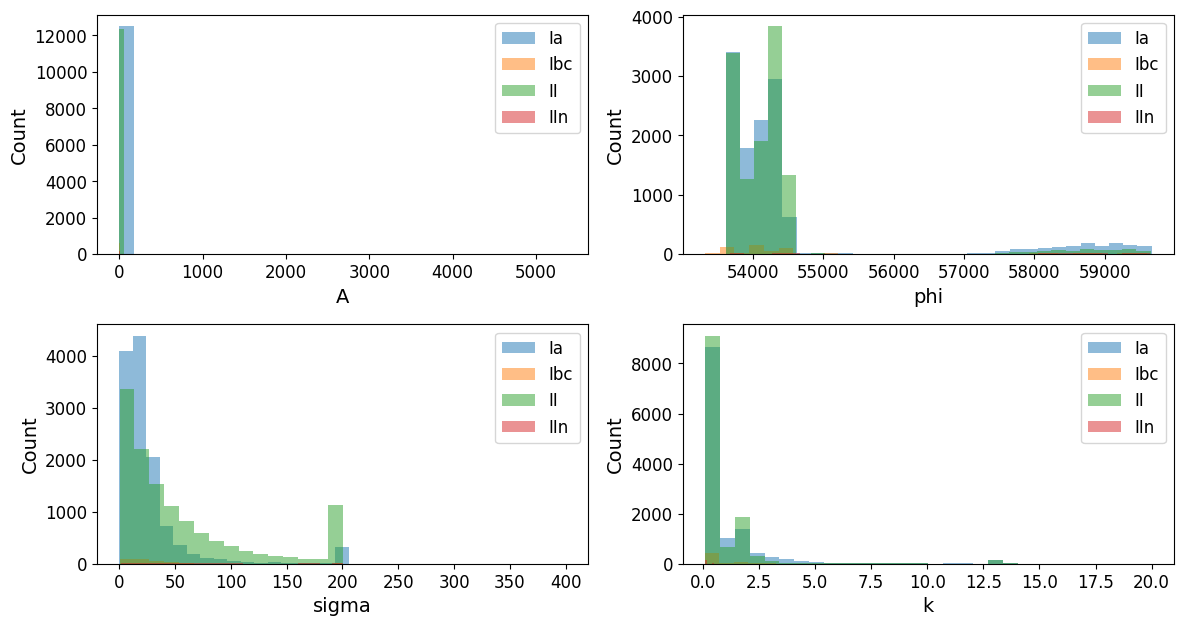

In [24]:
# Histograms for Model 1
histogram_all([I_Ia, I_Ibc, I_II, I_IIn], I_skip, I_labels)

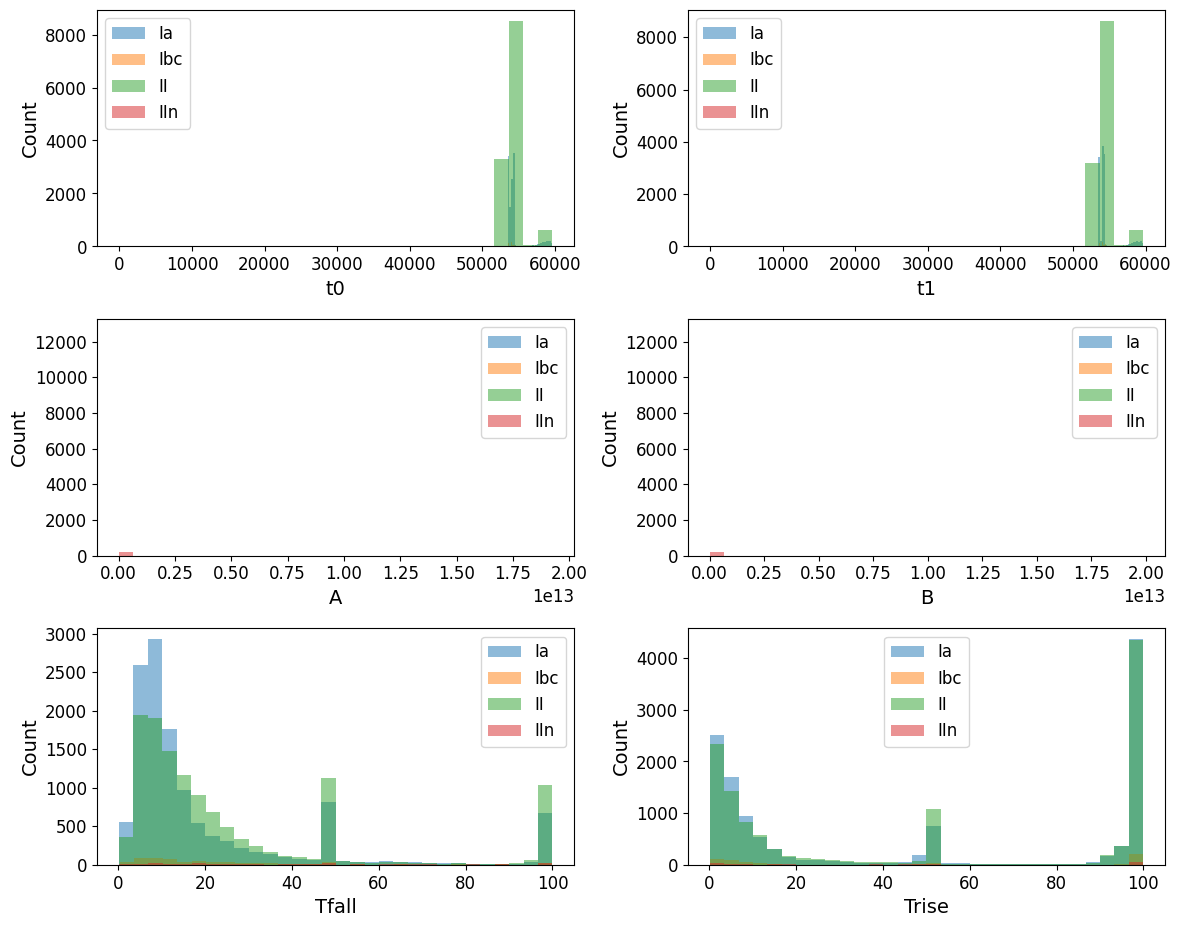

In [25]:
# Histograms for Model 2
histogram_all([II_Ia,II_Ibc,II_II,II_IIn],II_skip,II_labels)

Both these datasets show presence of outliers, which can skew the model. We use clipping technique to squeeze both dataset to their 25-75quantile intervals.

In [26]:
def clipping(dfs, skip):
    dfs_clipped = []
    feature_cols = dfs[0].columns[3:]

    for df in dfs:
        df_copy = df.copy()

        # Compute IQR only on feature columns
        Q1 = df_copy[feature_cols].quantile(0.25)
        Q3 = df_copy[feature_cols].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Clip only the feature columns
        df_copy[feature_cols] = df_copy[feature_cols].clip(lower=lower, upper=upper, axis=1)

        dfs_clipped.append(df_copy)

    return dfs_clipped

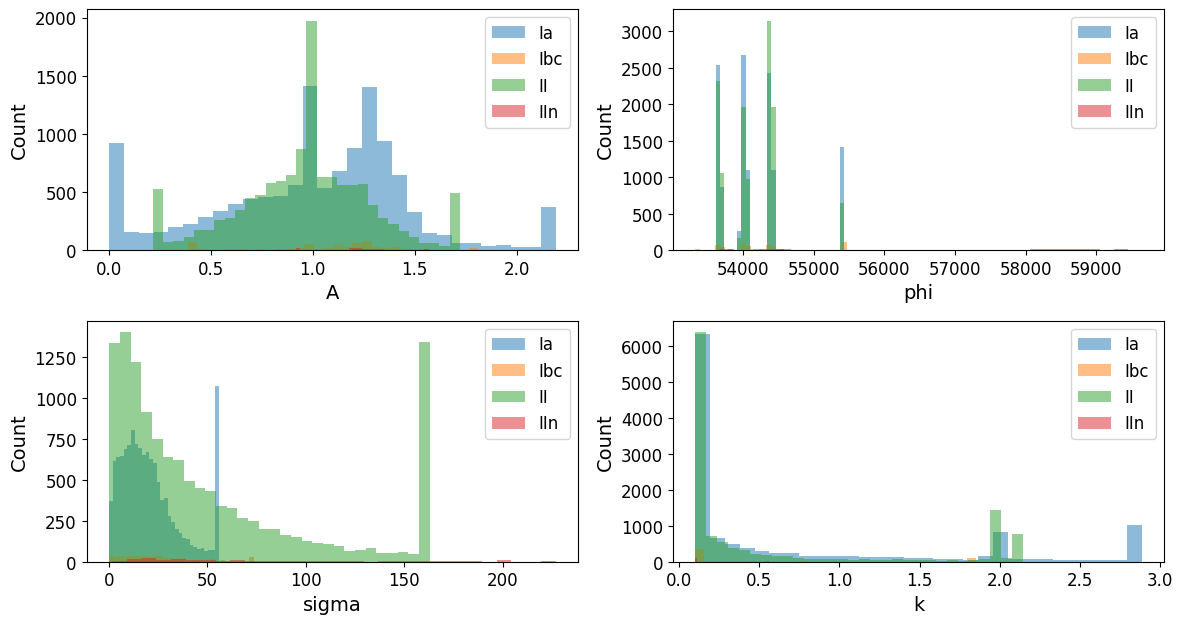

In [27]:
I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip = clipping([I_Ia,I_Ibc,I_II, I_IIn], I_skip)
histogram_all([I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip], I_skip, I_labels)

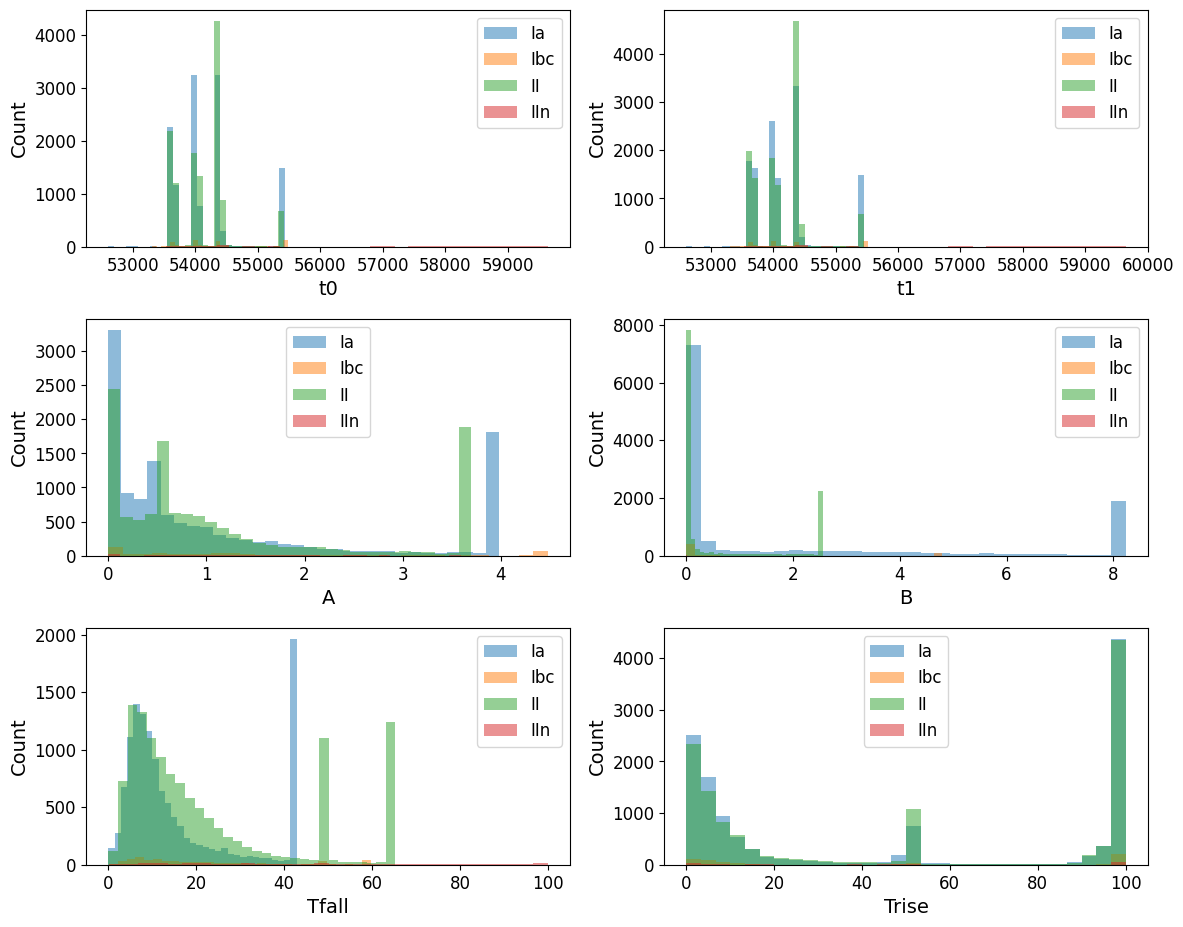

In [28]:
II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip = clipping([II_Ia,II_Ibc,II_II,II_IIn], II_skip)
histogram_all([II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip], II_skip, II_labels)

# Step 2: Prepare for training

In [29]:
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

## First, we define a function for evaluating performance of a model.

In [30]:
def evaluate_model(model, X_train, y_train, X_test, y_test, band_test, class_names=None, history=None):
  # Training set evaluation
  print("Training set:")
  y_train_pred_prob = model.predict(X_train)
  if history is not None:  # Keras
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)
  else:  # scikit-learn
    if hasattr(model, "predict_proba"):
      y_train_pred = np.argmax(y_train_pred_prob, axis=1)
    else:
      y_train_pred = y_train_pred_prob  # already class labels

  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("\nClassification report:\n", classification_report(y_train, y_train_pred))
  print("\nConfusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  # Test set evaluation
  print("\nTest set:")
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)

  # Predict probabilities
  if history is not None:
    y_score = model.predict(X_test)
  else:
    if hasattr(model, "predict_proba"):
      y_score = model.predict_proba(X_test)
    else:
      y_score = model.predict(X_test)
      # Convert to one-hot if needed
      y_score = label_binarize(y_score, classes=classes)

  # Compute ROC thresholds
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  roc_thresholds = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Youden's J statistic
    J = tpr[i] - fpr[i]
    ix = np.argmax(J)
    roc_thresholds[i] = thresholds[ix]

  # Predict labels using ROC thresholds
  y_test_pred = np.full(X_test.shape[0], -1, dtype=int)  # -1 = uncertain (optional)

  not_classified = 0
  for j in range(X_test.shape[0]):
    above_thresh = [i for i in range(n_classes) if y_score[j, i] >= roc_thresholds[i]]
    if above_thresh:
      # choose class with highest probability among those exceeding threshold
      y_test_pred[j] = above_thresh[np.argmax([y_score[j, i] for i in above_thresh])]
    else:
      # fallback to most probable class
      # y_test_pred[j] = np.argmax(y_score[j, :])
      not_classified += 1

  print("\nNot classified:", not_classified)

  mask = y_test_pred != -1
  print("Accuracy:", accuracy_score(y_test[mask], y_test_pred[mask]))
  print("\nClassification report:\n", classification_report(y_test[mask], y_test_pred[mask]))
  print("\nConfusion matrix:\n", confusion_matrix(y_test[mask], y_test_pred[mask]))

  # Plot the ROC curves
  plt.figure(figsize=(7,6))

  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'{label} (AUC = {roc_auc[i]:.2f}, Threshold = {roc_thresholds[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

  # Plot XGBClassifier train/val loss if available
  if hasattr(model, "evals_result"):
    try:
      results = model.evals_result()
    except:
      results = model.get_booster().evals_result()

    # print("\nEvals result keys:", results.keys())  # debug

    # mlogloss is your eval_metric
    train_key = list(results.keys())[0]
    val_key  = list(results.keys())[1]

    metric_name = list(results[train_key].keys())[0]

    train_loss = results[train_key][metric_name]
    val_loss   = results[val_key][metric_name]

    plt.figure(figsize=(7,6))
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.xlabel("Boosting Rounds")
    plt.ylabel('Loss')
    plt.title("XGBoost Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  # Plot MLPClassifier train/val loss if available
  if history is not None:
    plt.figure(figsize=(7,6))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("MLP Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  if band_test is not None:
      print("\n==============================")
      print(" Per-band evaluation:")
      print("==============================")

      bands = sorted(band_test.unique())
      y_test_pred_all = model.predict(X_test)
      if history is not None:
          y_test_pred_all = np.argmax(y_test_pred_all, axis=1)

      for b in bands:
          idx = (band_test == b)
          y_true_b = y_test[idx]
          y_pred_b = y_test_pred_all[idx]

          print(f"\n--- Band = {b} ---")
          print("Count:", len(y_true_b))
          if len(y_true_b) == 0:
              print("No samples in this band.")
              continue

          print("Accuracy:", accuracy_score(y_true_b, y_pred_b))
          print(classification_report(y_true_b, y_pred_b))
          print("Confusion matrix:\n", confusion_matrix(y_true_b, y_pred_b))


## Second, we prepare features and labels.

In [31]:
# Model 1:
# Combining into a single dataset
I = pd.concat([I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip], ignore_index=True)
I = I.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_feature_cols = [c for c in I.columns if c not in I_skip]
I_X = I[I_feature_cols]
I_band = I['band']

# Extracting labels
I_y = I['sn_type']
#print("Unique mapped labels:", I_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II, and 3 for IIn
I_name_Ia = ['Ia','IaQ','Ia_Pec']
I_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
I_name_IIn = ['IIn', 'IIn_LBV', 'IIn_Pec']
I_y = I_y.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else (3 if v in I_name_IIn else 1)))

# Split data into 70/20/10 and scale
I_X_temp, I_X_test, I_y_temp, I_y_test, I_band_temp, I_band_test = train_test_split(
    I_X, I_y, I_band,
    test_size=0.1,
    random_state=42,
    stratify=I_y,
    shuffle=True
)

I_X_train, I_X_val, I_y_train, I_y_val, I_band_train, I_band_val = train_test_split(
    I_X_temp, I_y_temp, I_band_temp,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=I_y_temp,
    shuffle=True
)

I_scaler = RobustScaler()
I_X_train = I_scaler.fit_transform(I_X_train)
I_X_val = I_scaler.fit_transform(I_X_val)
I_X_test = I_scaler.transform(I_X_test)

# Compute weights
I_classes = np.unique(I_y_train)
I_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=I_classes,
    y=I_y_train
)
I_class_weights = dict(zip(I_classes, I_class_weights))
I_sample_weights = np.array([I_class_weights[label] for label in I_y_train])

# Count examples in classes
print("Total:\n",pd.Series(I_y).value_counts())
print("Train:\n",pd.Series(I_y_train).value_counts())
print("Validation:\n",pd.Series(I_y_val).value_counts())
print("Test:\n",pd.Series(I_y_test).value_counts())

Total:
 sn_type
0    12528
2    12396
1      596
3      181
Name: count, dtype: int64
Train:
 sn_type
0    8769
2    8677
1     417
3     127
Name: count, dtype: int64
Validation:
 sn_type
0    2506
2    2479
1     119
3      36
Name: count, dtype: int64
Test:
 sn_type
0    1253
2    1240
1      60
3      18
Name: count, dtype: int64


In [33]:
# Model 2:
# Combining into a single dataset
II = pd.concat([II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II = II.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_feature_cols = [c for c in II.columns if c not in II_skip]
II_X = II[II_feature_cols]
II_band = II['band']

# Extracting labels
II_y = II['sn_type']

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II and 3 for IIn
II_name_Ia = ['Ia','IaQ','Ia_Pec']
II_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
II_name_IIn = ['IIn', 'IIn_LBV', 'IIn_Pec']
II_y = II_y.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))

# Split data 70/20/10 and scale
II_X_temp, II_X_test, II_y_temp, II_y_test, II_band_temp, II_band_test = train_test_split(
    II_X, II_y, II_band,
    test_size=0.1,
    random_state=42,
    stratify=II_y,
    shuffle=True
)

II_X_train, II_X_val, II_y_train, II_y_val, II_band_train, II_band_val = train_test_split(
    II_X_temp, II_y_temp, II_band_temp,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=II_y_temp,
    shuffle=True
)

II_scaler = RobustScaler()
II_X_train = II_scaler.fit_transform(II_X_train)
II_X_val = II_scaler.fit_transform(II_X_val)
II_X_test = II_scaler.transform(II_X_test)

# Compute weights
II_classes = np.unique(II_y_train)
II_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=II_classes,
    y=II_y_train
)
II_class_weights = dict(zip(II_classes, II_class_weights))
II_sample_weights = np.array([II_class_weights[label] for label in II_y_train])

# Count examples in classes
print("Total:\n",pd.Series(II_y).value_counts())
print("Train:\n",pd.Series(II_y_train).value_counts())
print("Validation:\n",pd.Series(II_y_val).value_counts())
print("Test:\n",pd.Series(II_y_test).value_counts())

Total:
 sn_type
0    12637
2    12481
1      604
3      199
Name: count, dtype: int64
Train:
 sn_type
0    8846
2    8736
1     423
3     139
Name: count, dtype: int64
Validation:
 sn_type
0    2527
2    2496
1     121
3      40
Name: count, dtype: int64
Test:
 sn_type
0    1264
2    1249
1      60
3      20
Name: count, dtype: int64


It can be seen that both datasets have very strong imbalance between classes. We try downsampling.

In [34]:
# Model 1:
# Combining into a single dataset
I_down = pd.concat([I_Ia_clip.sample(1000), I_Ibc_clip, I_II_clip.sample(1000), I_IIn_clip], ignore_index=True)
I_down = I_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_X_down = I_down[I_feature_cols]
I_band_down = I_down['band']

# Extracting labels
I_y_down = I_down['sn_type']

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II
I_y_down = I_y_down.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else (3 if v in I_name_IIn else 1)))

# Split data into 70/20/10 and scale
I_X_temp_down, I_X_test_down, I_y_temp_down, I_y_test_down, I_band_temp_down, I_band_test_down = train_test_split(
    I_X_down, I_y_down, I_band_down,
    test_size=0.1,
    random_state=42,
    stratify=I_y_down,
    shuffle=True
)

I_X_train_down, I_X_val_down, I_y_train_down, I_y_val_down, I_band_train_down, I_band_val_down = train_test_split(
    I_X_temp_down, I_y_temp_down, I_band_temp_down,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=I_y_temp_down,
    shuffle=True
)

I_scaler_down = RobustScaler()
I_X_train_down = I_scaler_down.fit_transform(I_X_train_down)
I_X_val_down = I_scaler_down.fit_transform(I_X_val_down)
I_X_test_down = I_scaler_down.transform(I_X_test_down)

# Compute weights
I_class_weights_down = compute_class_weight(
    class_weight='balanced',
    classes=I_classes,
    y=I_y_train_down
)
I_class_weights_down = dict(zip(I_classes, I_class_weights_down))
I_sample_weights_down = np.array([I_class_weights_down[label] for label in I_y_train_down])

# Count examples in classes
print("Total:\n",pd.Series(I_y_down).value_counts())
print("Train:\n",pd.Series(I_y_train_down).value_counts())
print("Validation:\n",pd.Series(I_y_val_down).value_counts())
print("Test:\n",pd.Series(I_y_test_down).value_counts())

Total:
 sn_type
0    1000
2    1000
1     596
3     181
Name: count, dtype: int64
Train:
 sn_type
2    700
0    700
1    417
3    126
Name: count, dtype: int64
Validation:
 sn_type
0    200
2    200
1    119
3     37
Name: count, dtype: int64
Test:
 sn_type
0    100
2    100
1     60
3     18
Name: count, dtype: int64


In [36]:
# Model 2:
# Combining into a single dataset
II_down = pd.concat([II_Ia_clip.sample(1000), II_Ibc_clip, II_II_clip.sample(1000), II_IIn_clip], ignore_index=True)
II_down = II_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_X_down = II_down[II_feature_cols]
II_band_down = II_down['band']

# Extracting labels
II_y_down = II_down['sn_type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels
II_y_down = II_y_down.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))

# Split data into 70/20/10 and scale
II_X_temp_down, II_X_test_down, II_y_temp_down, II_y_test_down, II_band_temp_down, II_band_test_down = train_test_split(
    II_X_down, II_y_down, II_band_down,
    test_size=0.1,
    random_state=42,
    stratify=II_y_down,
    shuffle=True
)

II_X_train_down, II_X_val_down, II_y_train_down, II_y_val_down, II_band_train_down, II_band_val_down = train_test_split(
    II_X_temp_down, II_y_temp_down, II_band_temp_down,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=II_y_temp_down,
    shuffle=True
)

II_scaler_down = RobustScaler()
II_X_train_down = II_scaler_down.fit_transform(II_X_train_down)
II_X_val_down = II_scaler_down.fit_transform(II_X_val_down)
II_X_test_down = II_scaler_down.transform(II_X_test_down)

# Compute weights
II_class_weights_down = compute_class_weight(
    class_weight='balanced',
    classes=II_classes,
    y=II_y_train_down
)
II_class_weights_down = dict(zip(II_classes, II_class_weights_down))
II_sample_weights_down = np.array([II_class_weights_down[label] for label in II_y_train_down])

# Count examples in classes
print("Total:\n",pd.Series(II_y_down).value_counts())
print("Train:\n",pd.Series(II_y_train_down).value_counts())
print("Validation:\n",pd.Series(II_y_val_down).value_counts())
print("Test:\n",pd.Series(II_y_test_down).value_counts())

Total:
 sn_type
2    1000
0    1000
1     604
3     199
Name: count, dtype: int64
Train:
 sn_type
0    700
2    700
1    422
3    139
Name: count, dtype: int64
Validation:
 sn_type
0    200
2    200
1    121
3     40
Name: count, dtype: int64
Test:
 sn_type
2    100
0    100
1     61
3     20
Name: count, dtype: int64


# Step 3: Multi-layer perceptron classifier

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

## Model 1

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2774 - loss: 1.8113 - val_accuracy: 0.4920 - val_loss: 1.3116
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3078 - loss: 1.6087 - val_accuracy: 0.5173 - val_loss: 1.2494
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3364 - loss: 1.4775 - val_accuracy: 0.4963 - val_loss: 1.2211
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3525 - loss: 1.4509 - val_accuracy: 0.5023 - val_loss: 1.2120
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3543 - loss: 1.4557 - val_accuracy: 0.4856 - val_loss: 1.2046
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3654 - loss: 1.4300 - val_accuracy: 0.4763 - val_loss: 1.1995
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3675 - loss: 1.3335 - val_accuracy: 0.4667 - val_loss: 1.1884
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3809 - loss: 1.4192 - val_acc

/tmp/ipython-input-284888645.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


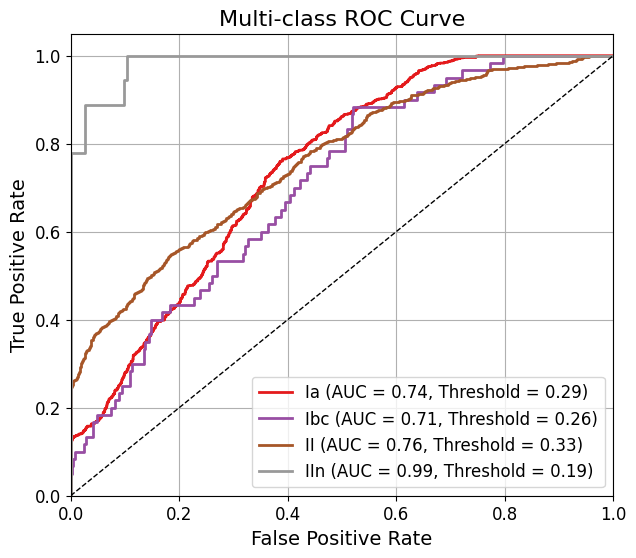

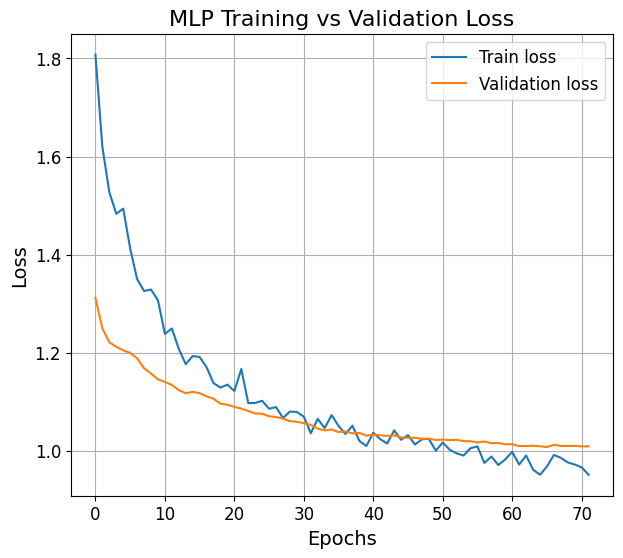


 Per-band evaluation:
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Band = G ---
Count: 250
Accuracy: 0.176
              precision    recall  f1-score   support

           0       0.86      0.12      0.21       161
           1       0.05      0.83      0.10        12
           2       0.25      0.02      0.03        63
           3       0.48      1.00      0.65        14

    accuracy                           0.18       250
   macro avg       0.41      0.49      0.25       250
weighted avg       0.65      0.18      0.18       250

Confusion matrix:
 [[ 19 139   3   0]
 [  0  10   0   2]
 [  3  46   1  13]
 [  0   0   0  14]]

--- Band = g' ---
Count: 418
Accuracy: 0.583732057416268
              precision    recall  f1-score   support

           0       0.70      0.67      0.68       192
           1       0.03      0.38      0.06         8
           2       0.86      0.52      0.65       218
           3       0.00      0.00      0.00         0

    accuracy                    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

In [68]:
# Model 1 without downsampling
I_mlp = models.Sequential([
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

I_mlp.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I_history = I_mlp.fit(
    I_X_train, I_y_train,
    validation_data=(I_X_val, I_y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=I_class_weights
)

evaluate_model(I_mlp, I_X_train, I_y_train, I_X_test, I_y_test, I_band_test, I_labels, I_history)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.2384 - loss: 1.9343 - val_accuracy: 0.2986 - val_loss: 1.3838
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2612 - loss: 1.7298 - val_accuracy: 0.3076 - val_loss: 1.3628
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2510 - loss: 1.6773 - val_accuracy: 0.3201 - val_loss: 1.3448
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2989 - loss: 1.5297 - val_accuracy: 0.3705 - val_loss: 1.3257
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2973 - loss: 1.5197 - val_accuracy: 0.3687 - val_loss: 1.3105
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3096 - loss: 1.4358 - val_accuracy: 0.3813 - val_loss: 1.2939
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2897 - loss: 1.4185 - val_accuracy: 0.4101 - val_loss: 1.2755
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3090 - loss: 1.4186 - val_accuracy: 0.41

/tmp/ipython-input-284888645.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


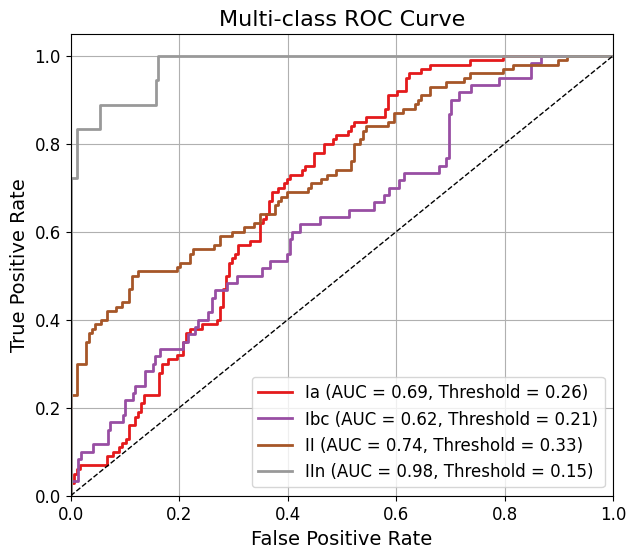

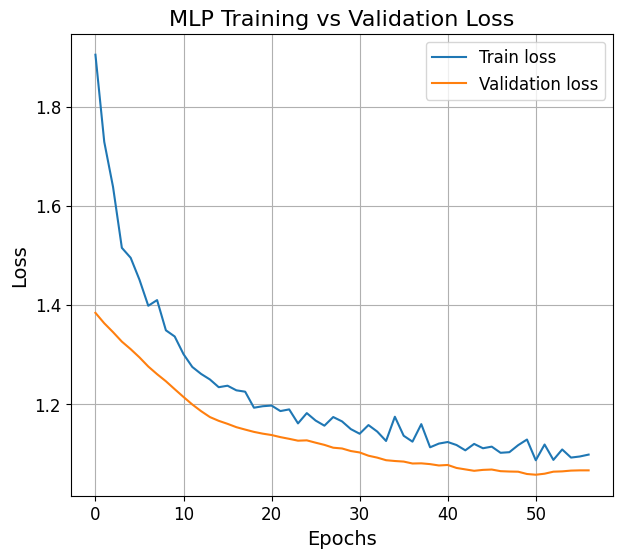


 Per-band evaluation:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Band = G ---
Count: 40
Accuracy: 0.675
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.47      0.78      0.58         9
           2       0.00      0.00      0.00         5
           3       0.87      1.00      0.93        13

    accuracy                           0.68        40
   macro avg       0.51      0.58      0.53        40
weighted avg       0.61      0.68      0.63        40

Confusion matrix:
 [[ 7  5  0  1]
 [ 1  7  0  1]
 [ 2  3  0  0]
 [ 0  0  0 13]]

--- Band = g' ---
Count: 43
Accuracy: 0.6511627906976745
              precision    recall  f1-score   support

           0       0.61      0.85      0.71        20
           1       0.33      0.29      0.31         7
           2       1.00      0.56      0.72        16

    accuracy                           0.65        43
   macro avg       0.65      0.57      0.58       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [59]:
# Model 1 with downsampling
I_mlp_down = models.Sequential([
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

I_mlp_down.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I_history_down = I_mlp_down.fit(
    I_X_train_down, I_y_train_down,
    validation_data=(I_X_val_down, I_y_val_down),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=I_class_weights_down
)

evaluate_model(I_mlp_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_band_test_down, I_labels, I_history_down)

## Model 2

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1942 - loss: 2.4082 - val_accuracy: 0.0397 - val_loss: 1.7211
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2474 - loss: 1.8262 - val_accuracy: 0.1379 - val_loss: 1.6925
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2821 - loss: 1.5585 - val_accuracy: 0.2762 - val_loss: 1.5211
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3135 - loss: 1.5785 - val_accuracy: 0.3436 - val_loss: 1.3901
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3325 - loss: 1.4640 - val_accuracy: 0.3850 - val_loss: 1.3024
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3501 - loss: 1.4454 - val_accuracy: 0.4113 - val_loss: 1.2480
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3660 - loss: 1.3151 - val_accuracy: 0.4421 - val_loss: 1.2034
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3739 - loss: 1.3894 - val_acc

/tmp/ipython-input-284888645.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


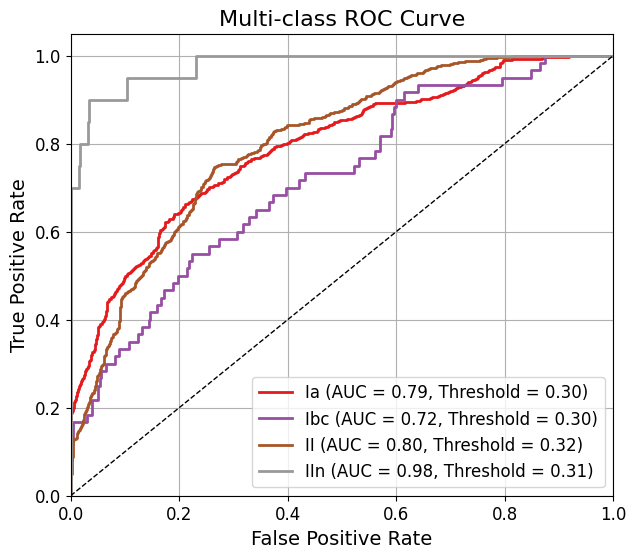

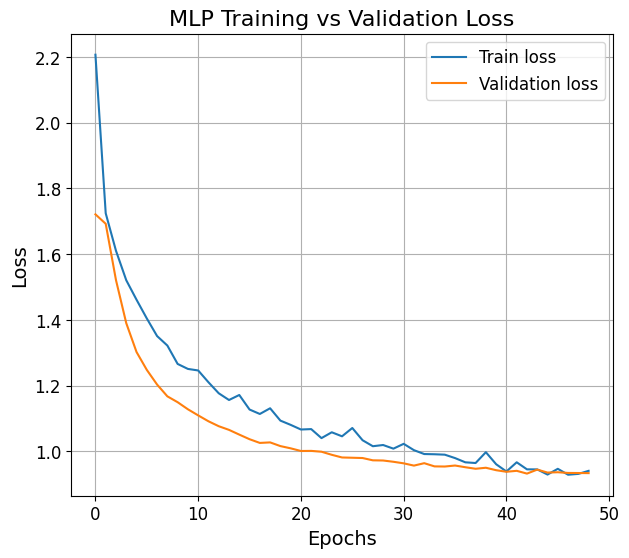


 Per-band evaluation:
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Band = G ---
Count: 248
Accuracy: 0.29435483870967744
              precision    recall  f1-score   support

           0       0.83      0.32      0.46       157
           1       0.05      0.69      0.10        13
           2       0.50      0.02      0.03        65
           3       0.72      1.00      0.84        13

    accuracy                           0.29       248
   macro avg       0.53      0.51      0.36       248
weighted avg       0.70      0.29      0.35       248

Confusion matrix:
 [[ 50 104   1   2]
 [  4   9   0   0]
 [  6  55   1   3]
 [  0   0   0  13]]

--- Band = g' ---
Count: 477
Accuracy: 0.6834381551362684
              precision    recall  f1-score   support

           0       0.84      0.63      0.72       232
           1       0.08      0.50      0.13         8
           2       0.74      0.74      0.74       236
           3       0.07      1.00      0.13         1

    accuracy     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

In [64]:
# Model 2 without downsampling
II_mlp = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(6,)),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

II_mlp.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

II_history = II_mlp.fit(
    II_X_train, II_y_train,
    validation_data=(II_X_val, II_y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=II_class_weights
)

evaluate_model(II_mlp, II_X_train, II_y_train, II_X_test, II_y_test, II_band_test,II_labels, II_history)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2752 - loss: 1.7760 - val_accuracy: 0.4278 - val_loss: 1.2346
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3355 - loss: 1.3703 - val_accuracy: 0.4920 - val_loss: 1.1500
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3617 - loss: 1.3404 - val_accuracy: 0.4955 - val_loss: 1.1033
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4100 - loss: 1.2186 - val_accuracy: 0.4848 - val_loss: 1.0806
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4186 - loss: 1.1534 - val_accuracy: 0.4938 - val_loss: 1.0615
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4313 - loss: 1.1289 - val_accuracy: 0.4991 - val_loss: 1.0428
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4241 - loss: 1.1125 - val_accuracy: 0.5027 - val_loss: 1.0390
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4311 - loss: 1.1248 - val_accuracy: 0.5045 - val_loss: 1.

/tmp/ipython-input-284888645.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


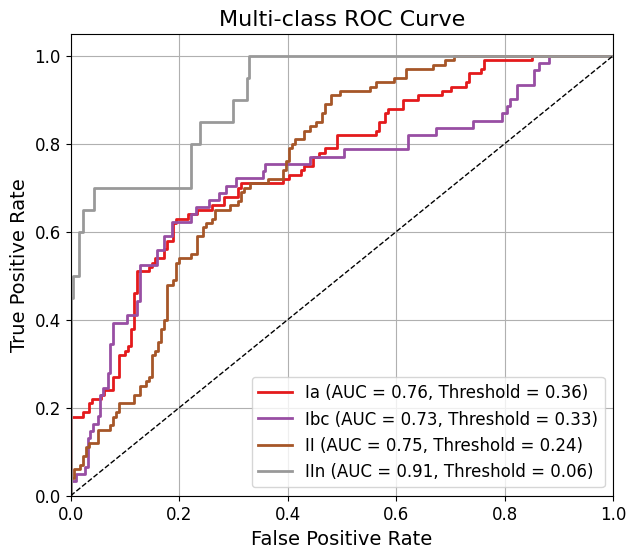

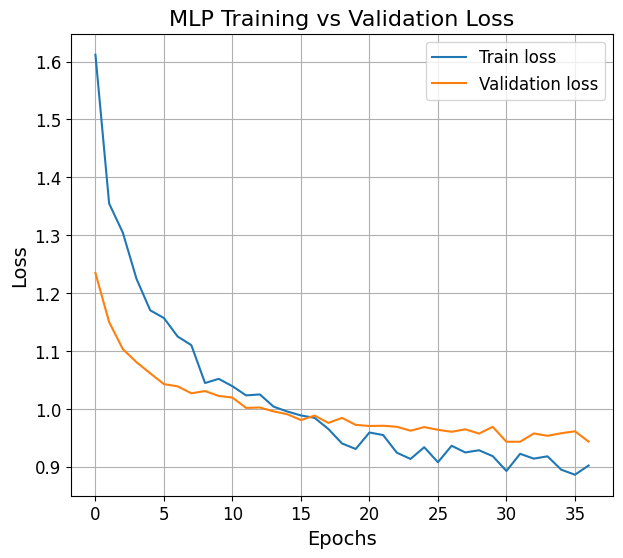


 Per-band evaluation:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Band = G ---
Count: 41
Accuracy: 0.6829268292682927
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.58      0.93      0.72        15
           2       0.00      0.00      0.00         6
           3       1.00      0.91      0.95        11

    accuracy                           0.68        41
   macro avg       0.56      0.57      0.55        41
weighted avg       0.63      0.68      0.64        41

Confusion matrix:
 [[ 4  5  0  0]
 [ 1 14  0  0]
 [ 1  5  0  0]
 [ 0  0  1 10]]

--- Band = g' ---
Count: 32
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.00      0.00      0.00         5
           2       0.75      0.92      0.83        13

    accuracy                           0.75        32
   macro avg       0.52      0.59      0.55        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
# Model 2 with downsampling
II_mlp_down = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(6,)),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

II_mlp_down.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

II_history_down = II_mlp_down.fit(
    II_X_train_down, II_y_train_down,
    validation_data=(II_X_val_down, II_y_val_down),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=II_class_weights_down
)

evaluate_model(II_mlp_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_band_test_down, II_labels, II_history_down)

Observation: Model 2 outperforms Model 1 with or without downsampling. Downsampling makes it worse for the classifier.

Conclusion:
- Data preprocessing is very important, which in our case is necessary to handle outliers.
- Model 2 outperforms Model 1. Probably because it has more features.
- Boosted decision tree classifier is the most effective, which agrees with the paper.
- Downsampling does not improve classification. The reason might be that our downsampling process results in a too small dataset, making it difficult for the classifiers to learn.
- In Model 2, we did a better job than the paper. Yay 😎!